# <center>  TWEETS DISASTER DETECTION </center>


![Sample Image](Twitter_X.png)

This task consists of building classification models classifying tweets indicating natural disaster and it is divided in the following sections:


## 1. Data Investigation
## 2. Data Preprocessing
## 3. Models Bulding, Evaluation and Comparison

let's first of all import all needed packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.stem import PorterStemmer  
from nltk.corpus import brown
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences

from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow_hub as hub
import tensorflow_text as text

from keras import models

from sklearn.feature_extraction.text import TfidfVectorizer

import collections
from scipy.optimize import curve_fit
from scipy.stats import norm 

C:\Users\ydg88\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('words')
nltk.download('brown')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\ydg88\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

### 1. Data Investigation

In [3]:
train_tweet=pd.read_csv(r'train.csv')  # load train dataset

In [4]:
train_tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### the above info and the first 5 rows of the dataframe provide us with the following information:
* presence of null values in 'keyword' and 'location' columns 
* special characters
* occasional capital letters
* 1/3 of null values in the'location' column
* id column can be safely dropped as it provides no useful information

### 2. Data Preprocessing

##### 2.1 Drop obsolete Columns 

In [6]:
target_list=train_tweet.target.tolist()  # save target variable into a list
train_tweet=train_tweet.drop(['id'], axis=1) # drop the id column
#train_tweet=train_tweet.drop(['target'], axis=1) # drop the target column, it will be added later

In [7]:
train_tweet.head() # dataframe without the 'id' column 

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


in order to eliminate all special characters and obtain a clean text, all null values need to be converted to string as 'type-float' values will generate errors

In [8]:
train_tweet['keyword'] = train_tweet['keyword'].fillna('key') # replace null values in 'keyword' with 'key'
train_tweet['location'] = train_tweet['location'].fillna('loc') # replace null values in 'keyword' with 'loc'

##### 2.2 Dataframe cleaning 
* __investigation target variable distribution__ - as we aim to obtain a balanced dataset
* __conversion of letters to lowercase__ - the same text is differently categorized depending upon their capitalization  e.g. A !=a
* __removal all special characters__ - dimensionality will be reduced by eliminating unwanted symbols e.g. #,@  providing no useful information
* __lemmatization__ - dimensionality will be further reduced by converting all words to their lemma e.g. updated = 'update' updating = 'update'
* __stopwords removal__ - removing most common words (stopwords) e.g. 'the' carrying no useful information will contribute to dimensionality reduction

 - __target variable distribution__ - balance dataset

0    4342
1    3271
Name: target, dtype: int64


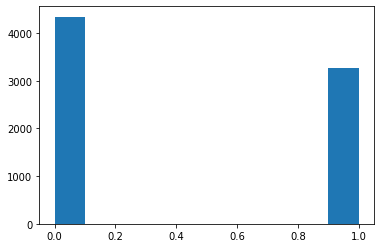

In [9]:
plt.hist(train_tweet.target)
print(train_tweet.target.value_counts())

the bar chart above shows that the number of tweets not indicating disaster are roughly 25% more than its counterpart, we will therefore remove random rows with 0 as the target value in order to have a balanced dataset 

In [10]:
target_percentage = 1-train_tweet.target.value_counts()[1]/train_tweet.target.value_counts()[0]
train_tweet = train_tweet.drop(train_tweet[train_tweet['target'] == 0].sample(frac=target_percentage).index)

1    3271
0    3271
Name: target, dtype: int64


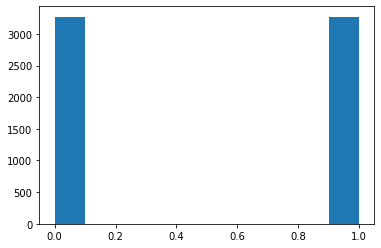

In [11]:
plt.hist(train_tweet.target)
print(train_tweet.target.value_counts())

now that we have a balanced dataset we can proceed with the remaining steps

 - __lowercase conversion and special characters removal__

In [12]:
def filter_clean(my_string, stop, lemmatizer):
    filter_non_letters = re.sub(r"[\W|\d]", ' ', my_string) # discard non-alphanumerical characters
    tokens= filter_non_letters.split() # tokenize
    lowercase= np.char.lower(tokens)  # convert to lowercase
    stopwords_in_sentence = np.intersect1d(np.array(stop), lowercase) # determine stopwords in sentence 
    filtered_stopwords = lowercase[~np.in1d(lowercase,stopwords_in_sentence)]  # filter out stopwords
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_stopwords if len(word)>2] # lemmatize tokens
    res = lemmatized_tokens
    return res

train_tweet['keyword_clean']=train_tweet['keyword'].apply( filter_clean,args= (stopwords.words('english'),
                                                          WordNetLemmatizer())) # apply filter_clean function to keyword col


train_tweet['text_clean']=train_tweet['text'].apply(filter_clean,args= (stopwords.words('english'), 
                                                    WordNetLemmatizer() )) # apply filter_clean function to text col

train_tweet.head(20)  # first 20 rows of dataset with original columns and their cleaned counterparts

,keyword,location,text,target,keyword_clean,text_clean
0,key,loc,Our Deeds are the Reason of this #earthquake M...,1,[key],"[deed, reason, earthquake, may, allah, forgive]"
1,key,loc,Forest fire near La Ronge Sask. Canada,1,[key],"[forest, fire, near, ronge, sask, canada]"
2,key,loc,All residents asked to 'shelter in place' are ...,1,[key],"[resident, asked, shelter, place, notified, of..."
3,key,loc,"13,000 people receive #wildfires evacuation or...",1,[key],"[people, receive, wildfire, evacuation, order,..."
4,key,loc,Just got sent this photo from Ruby #Alaska as ...,1,[key],"[got, sent, photo, ruby, alaska, smoke, wildfi..."
5,key,loc,#RockyFire Update => California Hwy. 20 closed...,1,[key],"[rockyfire, update, california, hwy, closed, d..."
6,key,loc,#flood #disaster Heavy rain causes flash flood...,1,[key],"[flood, disaster, heavy, rain, cause, flash, f..."
7,key,loc,I'm on top of the hill and I can see a fire in...,1,[key],"[top, hill, see, fire, wood]"
8,key,loc,There's an emergency evacuation happening now ...,1,[key],"[emergency, evacuation, happening, building, a..."
9,key,loc,I'm afraid that the tornado is coming to our a...,1,[key],"[afraid, tornado, coming, area]"


##### 2.3 investigation of unique words in dataframe  
numerous words could seldom appear in the dataframe enabling its dimensionality to be unnecessarily large, this is why an investigation of the frequency of all unique words will be performed and depending on their distribution, those falling below a certain threshold will be eliminated 

In [13]:
from collections import Counter
string_counter_text_clean_dict = dict(Counter(train_tweet['text_clean'].apply(lambda x: tuple(x)).explode()))
sorted_dict_string_counter_text_clean = dict(sorted(string_counter_text_clean_dict.items(), 
                                                    key=lambda item: item[1], reverse=True))

print(sorted_dict_string_counter_text_clean)
print(len(sorted_dict_string_counter_text_clean.keys()))

{'http': 4167, 'fire': 337, 'like': 299, 'amp': 293, 'get': 202, 'news': 196, 'via': 193, 'new': 187, 'people': 178, 'year': 161, 'one': 160, 'time': 154, 'disaster': 151, 'video': 149, 'police': 142, 'home': 136, 'emergency': 135, 'building': 134, 'day': 127, 'family': 123, 'california': 120, 'body': 120, 'suicide': 120, 'storm': 117, 'bomb': 117, 'crash': 114, 'life': 113, 'would': 113, 'say': 113, 'train': 113, 'still': 108, 'burning': 108, 'car': 107, 'flood': 106, 'death': 106, 'world': 105, 'attack': 105, 'look': 104, 'man': 104, 'back': 102, 'know': 101, 'nuclear': 100, 'killed': 98, 'two': 97, 'hiroshima': 95, 'see': 94, 'first': 93, 'accident': 93, 'today': 90, 'war': 90, 'dead': 88, 'make': 87, 'old': 87, 'love': 86, 'got': 84, 'let': 84, 'wildfire': 81, 'going': 80, 'bombing': 79, 'youtube': 78, 'watch': 78, 'woman': 78, 'weapon': 78, 'want': 78, 'may': 77, 'injury': 77, 'service': 75, 'collapse': 75, 'way': 74, 'take': 74, 'ûªs': 74, 'good': 73, 'full': 73, 'many': 72, 'thi

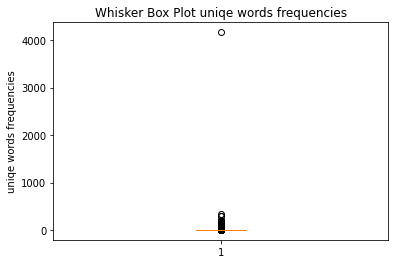

In [14]:
plt.boxplot(list(sorted_dict_string_counter_text_clean.values()))
plt.title('Whisker Box Plot uniqe words frequencies')
plt.ylabel('uniqe words frequencies')
plt.show()

there is a total of over 18000 unique tokens in the __text_clean__ column and the whisker box plot above clearly shows the presence of outliers which have to be removed in order to accurately model our unique words distribution

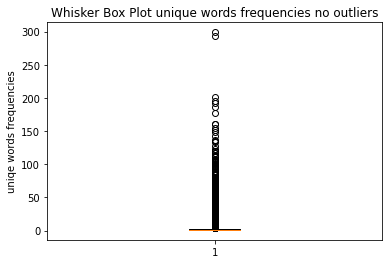

In [15]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def remove_outliers(data, z_threshold=10, iqr_multiplier=5000):
    values = np.array(data)

    # Calculate Z-scores
    z_scores = np.abs((values - np.mean(values)) / np.std(values))

    # Identify outliers based on Z-score
    outliers_z = values[z_scores > z_threshold]

    # Calculate Interquartile Range (IQR)
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    iqr = Q3 - Q1

    # Identify outliers based on IQR
    lower_bound = Q1 - iqr_multiplier * iqr
    upper_bound = Q3 + iqr_multiplier * iqr
    outliers_iqr = values[(values < lower_bound) | (values > upper_bound)]

    # Combine outliers identified by Z-score and IQR
    combined_outliers = np.union1d(outliers_z, outliers_iqr)

    # Filter out the outliers
    filtered_data = values[~np.isin(values, combined_outliers)]

    return filtered_data

data = list(sorted_dict_string_counter_text_clean.values())  # unique words frequencies
filtered_data = remove_outliers(data) # unique words frequencies without outliers

plt.boxplot(filtered_data)
plt.title('Whisker Box Plot unique words frequencies no outliers')
plt.ylabel('uniqe words frequencies')
plt.show()

 - despite the largest outlier being removed since the data still looks very skewed some of the highest values will be removed so that the frequency of the unique tokens can be modeled more effectively

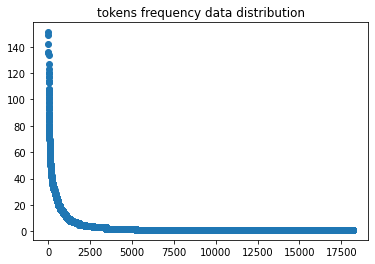

In [16]:
filtered_data_no_outliers=filtered_data[10:] # remove additional outliers 
# Provided data
x_data =np.arange(1, len(filtered_data_no_outliers)+1)  
y_data =filtered_data_no_outliers

plt.scatter(x_data, y_data, label= 'filtered data')
plt.title('tokens frequency data distribution')
plt.show()

- **Token Frequency Distribution:**
  - The distribution of token frequencies exhibits characteristics of exponential decay.
  - The flat segment of the curve represents tokens with low frequency.

- **Determination of Tokens to Remove:**
  - To decide which tokens to remove, an exponential decay function will be employed.
  - Parameters for this function will be selected and compared with the original dataset.

- **Evaluation Criteria:**
  - If the correlation coefficient (R-squared) is deemed satisfactory, further steps will be taken.

- **Precise Determination of Slope Change:**
  - A modified version of the exponential decay will be implemented (see (1)).
  - The derivative of the exponential decay will be calculated.
  - This calculation aims to precisely determine when the slope begins approaching zero.


The classic exponential decay will be equipped with the additional parameters $c$, $d$ and $e$ in order to reach the best possible fit

(1) $ f(x) = a \cdot e^{-b \cdot x} + \frac{c}{1 + e^{-(x - d) / e}} $

which will be compared with the actual values regarding the frequency of the tokens via the coefficient of determination R-squared as follows

(2) $ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $

Where:
-  $y_i$ represents the observed values,
- $ \hat{y}_i $ represents the predicted values,
- $ \bar{y} $ is the mean of the observed values,
- $ n $ is the number of data points.



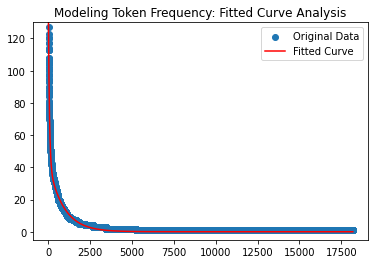

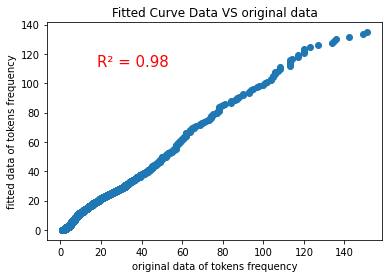

In [17]:
from sklearn.metrics import r2_score

filtered_data_no_outliers=filtered_data[10:] # remove 10 highest values
# Provided data
x_data =np.arange(1, len(filtered_data_no_outliers)+1)  
y_data =filtered_data_no_outliers

# Define the modified exponential decay model function
def modified_exponential_decay(x, a, b, c, d, e):
    return a * np.exp(-b * x) + c / (1 + np.exp(-(x - d) / e))

# Use curve_fit to find the best-fitting parameters
initial_guess = [y_data[0], 0.00012, 100, 100, 10]  # Adjust initial guesses depending upon the correlation
params, covariance = curve_fit(modified_exponential_decay, x_data, y_data, p0=initial_guess, maxfev=24000)

# Extract the best-fitting parameters
a_fit, b_fit, c_fit, d_fit, e_fit = params

# Generate fitted y values for the plot
y_fit = modified_exponential_decay(x_data, a_fit, b_fit, c_fit, d_fit, e_fit)  # eq (1)

plt.title('Modeling Token Frequency: Fitted Curve Analysis')
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, y_fit, color='red', label=f'Fitted Curve')
plt.ylim(-5, 130)
plt.legend()
plt.show()

plt.title('Fitted Curve Data VS original data')
plt.scatter(y_data, y_fit)
plt.xlabel('original data of tokens frequency')
plt.ylabel('fitted data of tokens frequency')
r_squared = r2_score(y_data, y_fit) # correlation coefficient
plt.annotate(f'R² = {r_squared:.2f}', xy=(0.15, 0.8), xycoords='axes fraction', fontsize=15, color='red')
plt.show()

T- **Visual Correlation Analysis:**
  - The visual depictions presented above substantiate a robust correlation existing between the frequency distribution of tokens and the applied exponential decay model utilized for representing their distributional characteristics.

- **R-squared Coefficient Analysis:**
  - The calculated R-squared coefficient of 98% serves as compelling evidence for the pronounced correlation observed between the original dataset and the fitted exponential decay model.

- **Foundation for Derivative Computation:**
  - These results provide the foundation for undertaking the computation of the derivative of the exponential decay function.

- **Precision in Slope Identification:**

    - The derivative of (1) is given by 

     (2) $ f'(x) = -a \cdot b \cdot e^{-b \cdot x} + \frac{c \cdot e^{-(x - d) / e}}{e \cdot (1 + e^{-(x - d) / e})^2} $

      where the distance between (1) and (2) falling below a preestablished threshold leads to the conclusion that (1) initiated its flattening trend

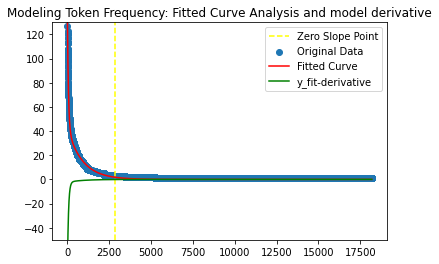

In [18]:
y_fit_derivative = np.gradient(y_fit, x_data[1]-x_data[0]) # eq (2)
tol = -0.002 # min distance between function and its derivative

constant_slope_starting_point = np.where(y_fit_derivative>tol)[0][0]
# Plot the original data and the fitted curve

plt.axvline(constant_slope_starting_point, color='yellow', linestyle='--', label='Zero Slope Point')
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, y_fit, color='red', label=f'Fitted Curve')

m = 50 # Increase the magnitude m of the derivative for better visualization
plt.plot(x_data, (y_fit_derivative)*m, color = 'green', label= 'y_fit-derivative') 
plt.ylim(-50, 130)

plt.title('Modeling Token Frequency: Fitted Curve Analysis and model derivative')
plt.legend()
plt.show()

- the analysis above enables to proceed with the selection of the tokens to be kept by discarding the ones having less frequency than the threshold determined by the slope of the exponential decay model

In [19]:
vals_to_include = list(set(filtered_data[:constant_slope_starting_point])) # values with frequency leq flat slope starting point
filtered_dict = {key: value for key, value in sorted_dict_string_counter_text_clean.items() if value in vals_to_include}
tokens_list = list(filtered_dict.keys()) # words to keep

def filter_tokens(token_list, tokens_to_keep):
    return [token for token in token_list if token in tokens_to_keep]

# Apply the function to filter rows
train_tweet['text_clean'] = train_tweet['text_clean'].apply(filter_tokens, tokens_to_keep=tokens_list)
train_tweet

,keyword,location,text,target,keyword_clean,text_clean
0,key,loc,Our Deeds are the Reason of this #earthquake M...,1,[key],"[reason, earthquake, may, allah]"
1,key,loc,Forest fire near La Ronge Sask. Canada,1,[key],"[forest, near, canada]"
2,key,loc,All residents asked to 'shelter in place' are ...,1,[key],"[resident, asked, shelter, place, officer, eva..."
3,key,loc,"13,000 people receive #wildfires evacuation or...",1,[key],"[people, wildfire, evacuation, order, california]"
4,key,loc,Just got sent this photo from Ruby #Alaska as ...,1,[key],"[got, sent, photo, alaska, smoke, wildfire, sc..."
...,...,...,...,...,...,...
7608,key,loc,Two giant cranes holding a bridge collapse int...,1,[key],"[two, giant, crane, holding, bridge, collapse,..."
7609,key,loc,@aria_ahrary @TheTawniest The out of control w...,1,[key],"[control, wild, california, even, northern, pa..."
7610,key,loc,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,[key],"[utc, volcano, hawaii]"
7611,key,loc,Police investigating after an e-bike collided ...,1,[key],"[police, investigating, bike, collided, car, l..."


In [20]:
# count all unique tokens and their frequency after filtering
def get_tokens_freq(df_col):
    all_tokens = [token for sublist in df_col for token in sublist]
    token_freq = Counter(all_tokens)
    return dict(token_freq)

token_with_min_freq = (min(get_tokens_freq(train_tweet['text_clean'] ).values()))
print(token_with_min_freq)

3



- Understanding the distribution of tokenized keywords is crucial for insights into prevalent themes or topics.
- Tokenization of the 'keyword_clean' column.
- Calculation of frequency percentage to identify frequently appearing key terms.
- Examination of the relationship between these key terms and the target variable.
- The analysis serves as a crucial step in preparing the data for exploration and modeling.
- It helps highlight essential patterns and trends related to the dataset's content.

In [21]:
# tokenize keyword column
train_tweet['keyword_clean'] = train_tweet['keyword_clean'].apply(lambda x: ', '.join(map(str, x)))

# tokenized keyword frequency
keyword_frequency_dictionary=dict(train_tweet.keyword_clean.value_counts()) 

# unique tokens in keywords
keyword_frequency_dictionary_keys=(list(keyword_frequency_dictionary.keys()))


keyword_frequency_percentage=([(str(round((i/train_tweet.shape[0]*100),2))+' %')
                               for i in keyword_frequency_dictionary.values()])

keyword_frequency_percentage_dict=dict(zip(keyword_frequency_dictionary_keys, keyword_frequency_percentage))

print('frequency percentage =', keyword_frequency_percentage_dict) # frequency percentage of unique keyword values in dataframe

frequency percentage = {'fatality': '1.15 %', 'weapon': '1.04 %', 'casualty': '0.98 %', 'flood': '0.98 %', 'death': '0.95 %', 'hostage': '0.95 %', 'injury': '0.92 %', 'key': '0.87 %', 'siren': '0.84 %', 'forest, fire': '0.73 %', 'body, bag': '0.7 %', 'outbreak': '0.61 %', 'wreckage': '0.6 %', 'derailment': '0.6 %', 'earthquake': '0.58 %', 'oil, spill': '0.58 %', 'typhoon': '0.58 %', 'collided': '0.57 %', 'fatal': '0.57 %', 'armageddon': '0.57 %', 'debris': '0.57 %', 'police': '0.57 %', 'collision': '0.55 %', 'damage': '0.55 %', 'harm': '0.55 %', 'ambulance': '0.55 %', 'derailed': '0.55 %', 'suicide, bomb': '0.54 %', 'pandemonium': '0.54 %', 'dust, storm': '0.54 %', 'razed': '0.54 %', 'evacuate': '0.54 %', 'attack': '0.54 %', 'evacuated': '0.54 %', 'devastation': '0.54 %', 'burning, building': '0.54 %', 'explosion': '0.54 %', 'famine': '0.54 %', 'nuclear, disaster': '0.52 %', 'thunder': '0.52 %', 'evacuation': '0.52 %', 'wounded': '0.52 %', 'sinkhole': '0.52 %', 'massacre': '0.52 %', 's

- **Keyword Distribution Analysis:**
  - The cell above aims to analyze and visualize the distribution of tokenized keywords in the 'keyword_clean' column of the 'train_tweet' DataFrame.

- **Tokenization Process:**
  - It initiates the process by tokenizing the keywords, creating a frequency dictionary to track the occurrence of each unique token.

- **Frequency Percentage Calculation:**
  - The resulting frequency percentage of unique keyword values is then printed, providing insights into the distribution of keywords in the dataset.

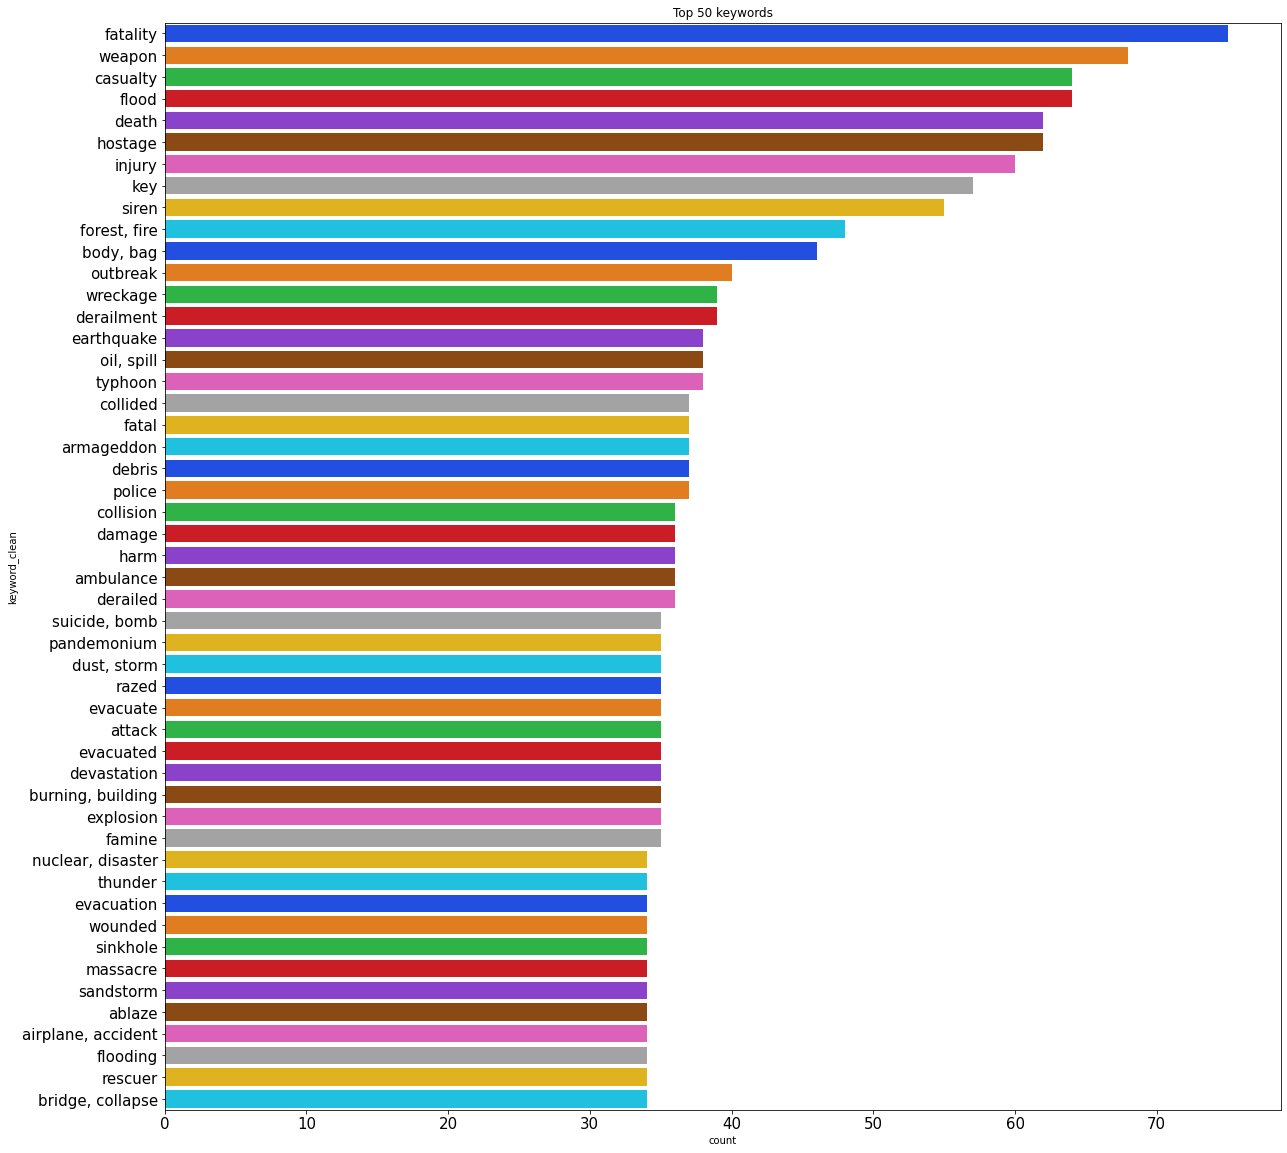

222


In [22]:
plt.figure(figsize=(20,20))
sns.countplot(y = train_tweet.keyword_clean, order = train_tweet.keyword_clean.value_counts().iloc[:50].index, palette='bright')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Top 50 keywords')
plt.show()
print(len(train_tweet.keyword.value_counts()))


- **Top 50 Keywords Distribution:**
  - The above bar-chart depicts the distribution of the top 50 keywords within the dataset, derived from the __keyword_clean__ column.

- **Bar-Chart Insights:**
  - Each bar in the count plot represents the frequency of a specific keyword, offering insights into the prevalence of terms in the dataset.

- **Further Analysis Consideration:**
  - To gain additional useful information, an analysis of frequency with respect to the target variable will be needed.


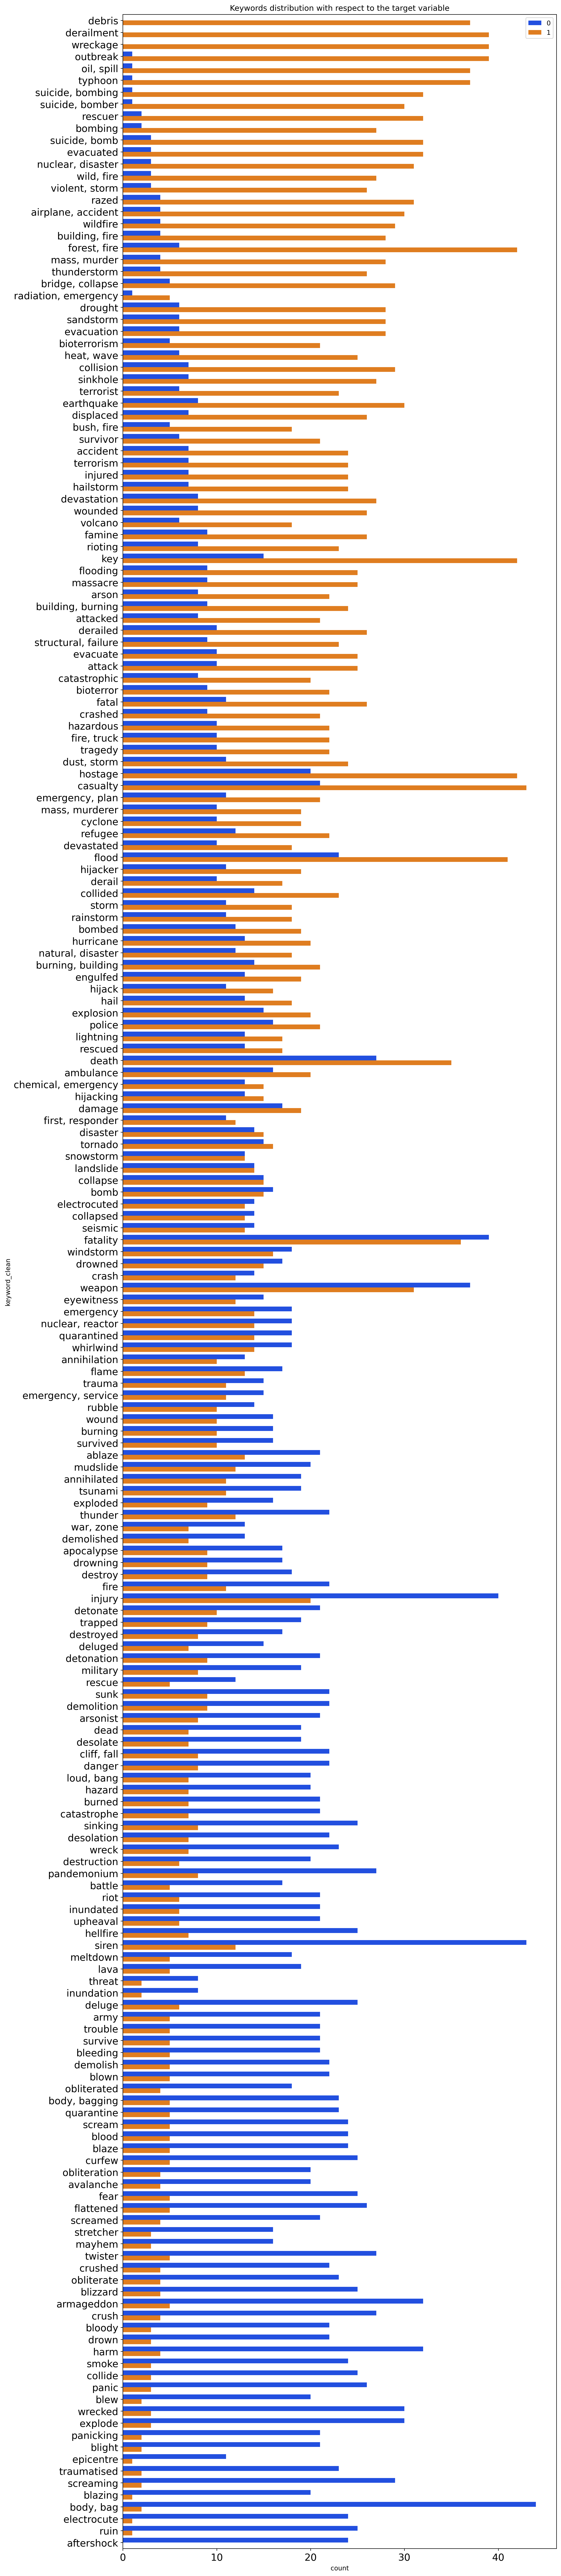

In [23]:
train_tweet['target_mean'] = train_tweet.groupby('keyword_clean')['target'].transform('mean')
fig = plt.figure(figsize=(12, 72), dpi=256)
sns.countplot(y=train_tweet.sort_values(by='target_mean', ascending=False)['keyword_clean'],
              hue=train_tweet.sort_values(by='target_mean', ascending=False)['target'], palette = "bright")

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.legend(loc=1)
plt.title('Keywords distribution with respect to the target variable')
plt.show()
train_tweet.drop(columns=['target_mean'], inplace=True)

- There is an observed correlation between specific keywords and the target variable e.g. the frequency of the first four words is between 30 and 40 and they all indicate a 'disaster'.
- As a result, cells under the __keyword__ column lacking a value will be assigned one.
- This assignment occurs whenever a keyword is identified in the corresponding cell under the __text_clean__ column.


In [24]:
def unique_tokens_set(df_col):
    tokens_set = (set([''.join(sublist) for sublist in df_col]))
     # Create a new set to store the split tokens
    split_tokens_set = set()

    # Iterate through the original set
    for token in tokens_set:
        # Split tokens containing more than one word
        split_tokens = token.split()
        
        # Remove commas from each split token and add to the new set
        split_tokens = [t.replace(',', '') for t in split_tokens]
        split_tokens_set.update(set(split_tokens))

    return split_tokens_set

unique_tokens = unique_tokens_set(train_tweet.keyword_clean)

print(unique_tokens)

{'hailstorm', 'lightning', 'ambulance', 'quarantined', 'destroyed', 'obliteration', 'bagging', 'outbreak', 'crashed', 'storm', 'tsunami', 'blazing', 'drowned', 'whirlwind', 'destroy', 'drowning', 'military', 'rescuer', 'bleeding', 'windstorm', 'hijacking', 'flooding', 'tragedy', 'scream', 'bomb', 'collided', 'deluged', 'obliterate', 'razed', 'ablaze', 'sandstorm', 'sunk', 'lava', 'derail', 'dead', 'catastrophic', 'hurricane', 'obliterated', 'responder', 'attacked', 'explode', 'blown', 'harm', 'oil', 'bomber', 'rescue', 'drown', 'flattened', 'screamed', 'earthquake', 'attack', 'threat', 'traumatised', 'survived', 'thunderstorm', 'evacuation', 'eyewitness', 'blizzard', 'upheaval', 'structural', 'hellfire', 'smoke', 'building', 'wound', 'murderer', 'airplane', 'weapon', 'typhoon', 'war', 'devastation', 'blaze', 'plan', 'damage', 'desolate', 'blood', 'inundation', 'service', 'flame', 'blight', 'evacuated', 'hijack', 'crushed', 'hazardous', 'survivor', 'wildfire', 'volcano', 'wild', 'desola

In [25]:
# Find and print the tokens from each sublist that are present in the set
present_tokens = [[token for token in sublist if token in unique_tokens] for sublist in list(train_tweet['text_clean'])]

# additional keywords in column: fewer empty entries
train_tweet['keyword_clean'] = present_tokens

In [26]:
train_tweet.head(20)

,keyword,location,text,target,keyword_clean,text_clean
0,key,loc,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],"[reason, earthquake, may, allah]"
1,key,loc,Forest fire near La Ronge Sask. Canada,1,[forest],"[forest, near, canada]"
2,key,loc,All residents asked to 'shelter in place' are ...,1,[evacuation],"[resident, asked, shelter, place, officer, eva..."
3,key,loc,"13,000 people receive #wildfires evacuation or...",1,"[wildfire, evacuation]","[people, wildfire, evacuation, order, california]"
4,key,loc,Just got sent this photo from Ruby #Alaska as ...,1,"[smoke, wildfire]","[got, sent, photo, alaska, smoke, wildfire, sc..."
5,key,loc,#RockyFire Update => California Hwy. 20 closed...,1,[wildfire],"[rockyfire, update, california, hwy, closed, d..."
6,key,loc,#flood #disaster Heavy rain causes flash flood...,1,"[flood, disaster, flooding]","[flood, disaster, heavy, rain, cause, flash, f..."
7,key,loc,I'm on top of the hill and I can see a fire in...,1,[],"[top, hill, see, wood]"
8,key,loc,There's an emergency evacuation happening now ...,1,"[emergency, evacuation, building]","[emergency, evacuation, happening, building, a..."
9,key,loc,I'm afraid that the tornado is coming to our a...,1,[tornado],"[afraid, tornado, coming, area]"


- __location__ column frequency investigation

In [27]:
dict_loc=dict(train_tweet.location.value_counts()) # word frequency dictionary
print([str(round((i/train_tweet.shape[0])*100,2))+' %' for i in dict_loc.values()])

['33.11 %', '1.44 %', '0.87 %', '0.67 %', '0.55 %', '0.4 %', '0.4 %', '0.37 %', '0.37 %', '0.34 %', '0.34 %', '0.32 %', '0.28 %', '0.26 %', '0.26 %', '0.24 %', '0.21 %', '0.2 %', '0.2 %', '0.2 %', '0.2 %', '0.2 %', '0.18 %', '0.18 %', '0.18 %', '0.18 %', '0.17 %', '0.17 %', '0.17 %', '0.15 %', '0.15 %', '0.15 %', '0.14 %', '0.14 %', '0.14 %', '0.14 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.12 %', '0.11 %', '0.11 %', '0.11 %', '0.11 %', '0.11 %', '0.11 %', '0.11 %', '0.11 %', '0.11 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.09 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.08 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06 %', '0.06

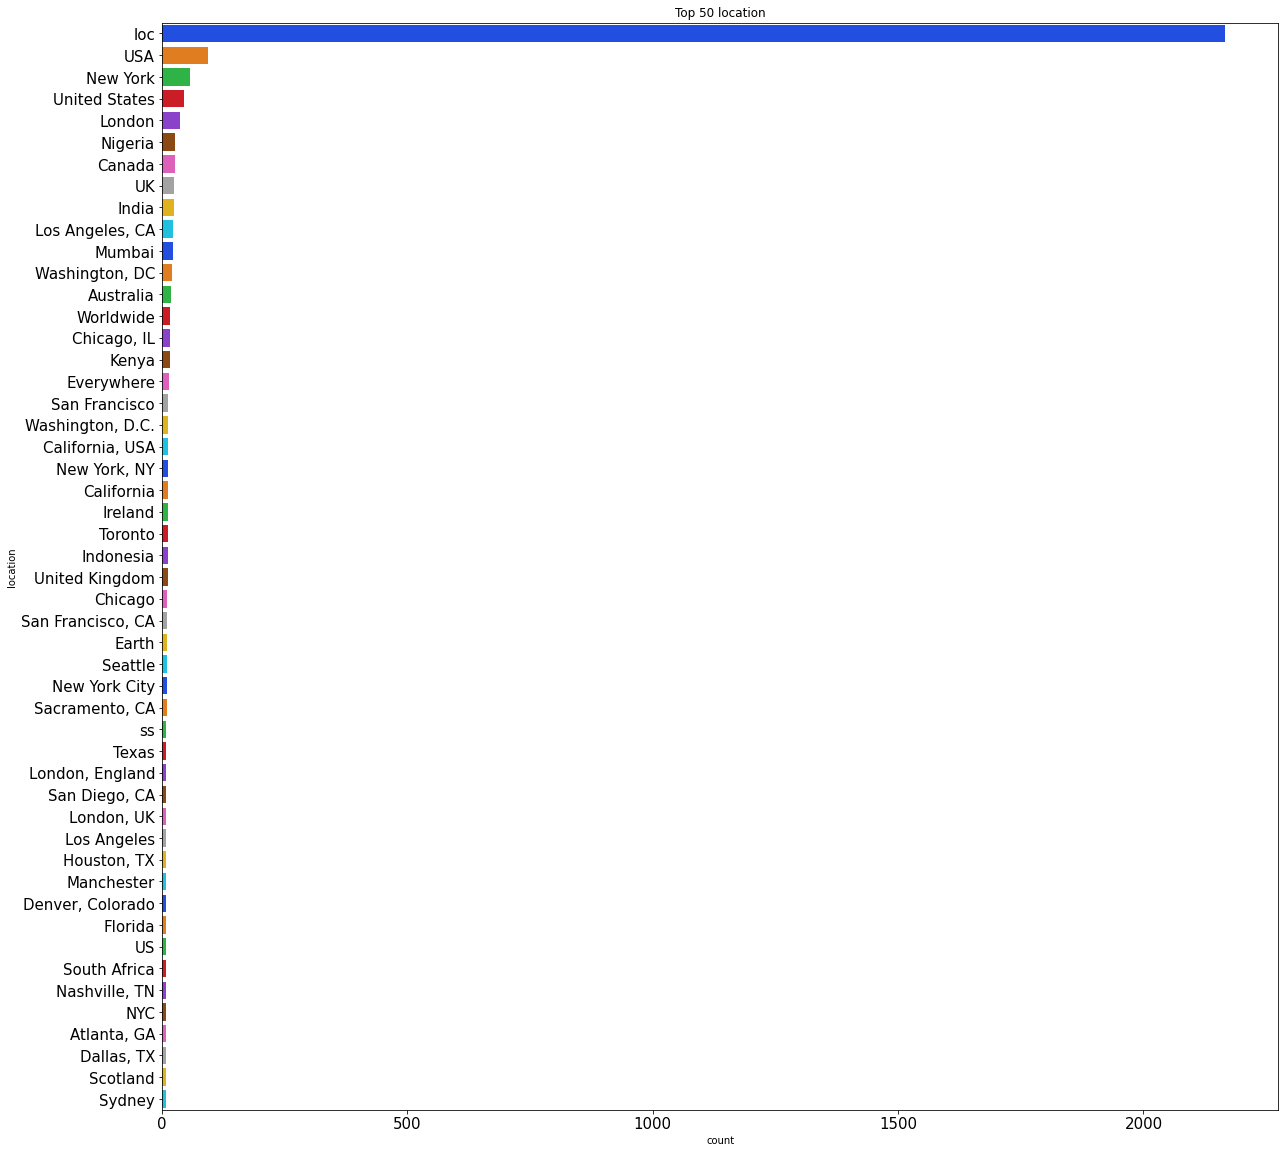

(6542, 6)


In [28]:
plt.figure(figsize=(20,20))
sns.countplot(y = train_tweet.location, order = train_tweet.location.value_counts().iloc[:50].index, palette='bright')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Top 50 location')
plt.show()
print(train_tweet.shape)

- The dataframe contains 6542 rows, and 33.3% of them are NaN values (converted to 'locs').
- The second most frequent value ('usas') accounts for less than 1.5% of the entire __location__ column.
- Consequently, it can be safely dropped.


In [29]:
train_tweet=train_tweet.drop(['location', 'keyword'], axis=1) # drop location and keyword column
train_tweet.head()

,text,target,keyword_clean,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],"[reason, earthquake, may, allah]"
1,Forest fire near La Ronge Sask. Canada,1,[forest],"[forest, near, canada]"
2,All residents asked to 'shelter in place' are ...,1,[evacuation],"[resident, asked, shelter, place, officer, eva..."
3,"13,000 people receive #wildfires evacuation or...",1,"[wildfire, evacuation]","[people, wildfire, evacuation, order, california]"
4,Just got sent this photo from Ruby #Alaska as ...,1,"[smoke, wildfire]","[got, sent, photo, alaska, smoke, wildfire, sc..."


- Unique Words Frequency
    * check frequency of unique words with respect to the target variable 

In [30]:
train_tweet['text_clean_str'] = train_tweet['text_clean'].apply(lambda keyword_text_length:
 ' '.join(keyword_text_length))

In [31]:
# Create a new column 'unique_text' containing lists of unique words
# obtained by splitting and removing duplicates from the 'text_clean_str' column
train_tweet['unique_text'] = train_tweet['text_clean_str'].apply(lambda x: list(set(x.split())))

In [32]:
train_tweet_target_1 = train_tweet[train_tweet['target'] != 0] 
train_tweet_target_0 = train_tweet[train_tweet['target'] != 1] 



string_counter_text_clean_dict_target_1 = dict(Counter(train_tweet_target_1['unique_text'].apply(lambda x: tuple(x)).explode()))
sorted_dict_string_counter_text_clean_target_1 = dict(sorted(string_counter_text_clean_dict_target_1.items(), 
                                                    key=lambda item: item[1], reverse=True))

print(sorted_dict_string_counter_text_clean_target_1)

string_counter_text_clean_dict_target_0 = dict(Counter(train_tweet_target_0['unique_text'].apply(lambda x: tuple(x)).explode()))
sorted_dict_string_counter_text_clean_target_0 = dict(sorted(string_counter_text_clean_dict_target_0.items(), 
                                                    key=lambda item: item[1], reverse=True))

print(sorted_dict_string_counter_text_clean_target_0)

{'news': 142, 'via': 121, 'amp': 113, 'california': 112, 'suicide': 106, 'people': 102, 'disaster': 101, 'year': 101, 'home': 100, 'police': 97, 'train': 94, 'building': 92, 'killed': 92, 'storm': 91, 'bomb': 91, 'like': 90, 'hiroshima': 89, 'crash': 84, 'family': 80, 'wildfire': 78, 'flood': 76, 'emergency': 76, 'accident': 74, 'bombing': 74, 'attack': 73, 'time': 72, 'car': 71, 'nuclear': 71, 'get': 70, 'video': 70, 'two': 68, 'say': 67, 'death': 66, 'one': 66, 'northern': 64, 'burning': 63, 'dead': 60, 'life': 59, 'war': 59, 'old': 58, 'bomber': 58, 'still': 56, 'collapse': 56, 'fatal': 55, 'today': 55, 'new': 55, 'atomic': 55, 'typhoon': 55, 'japan': 53, 'kill': 52, 'warning': 50, 'watch': 50, 'water': 50, 'debris': 49, 'report': 49, 'mass': 49, 'may': 48, 'forest': 48, 'first': 48, 'malaysia': 48, 'near': 47, 'man': 47, 'look': 47, 'latest': 47, 'thunderstorm': 47, 'day': 46, 'injured': 45, 'hostage': 45, 'confirmed': 45, 'area': 44, 'world': 44, 'city': 44, 'casualty': 44, 'sever

- To streamline dimensionality, we are investigating the frequency of all unique words in relation to the target variable.
- The objective is to identify words whose frequency distribution across both categories is below a pre-established parameter, signifying a degree of similarity.
- These identified words will be selectively eliminated.
- This approach enhances the efficiency of our dimensionality reduction process and refines the feature set for subsequent analysis.


([<matplotlib.patches.Wedge at 0x20340411420>,
 [Text(-1.0905893385493104, -0.1435788795142854, 'token : said\n target = 1'),
  Text(1.0905893251064809, 0.14357898162262767, 'token : said\n target = 0')],
 [Text(-0.5948669119359874, -0.07831575246233749, '54.2%'),
  Text(0.594866904603535, 0.0783158081577969, '45.8%')])

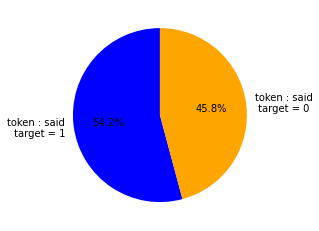

In [33]:
def compare_frequencies(dict1, dict2):
    # Get unique keys from both dictionaries
    keys1 = set(dict1.keys())
    keys2 = set(dict2.keys())

    # Create a union of unique keys
    all_keys = keys1.union(keys2)

    # Initialize dictionaries to store frequencies
    freq_dict1 = Counter(dict1)
    freq_dict2 = Counter(dict2)

    # Initialize a list to store results
    result_list = []

    # Iterate over unique keys and compare frequencies
    for key in all_keys:
        freq1 = freq_dict1.get(key, 0)
        freq2 = freq_dict2.get(key, 0)

        # Compare frequencies and append to the result list
        result_list.append((key, freq1, freq2))

    # Return the list of results
    return result_list


# frequency of tokens grouped by target value
word_ratio_cases=(compare_frequencies(sorted_dict_string_counter_text_clean_target_1,
                                         sorted_dict_string_counter_text_clean_target_0))

# index of instance with similar frequency in both classes
said_index = [index for index, tpl in enumerate(word_ratio_cases) if 'said' in tpl] # string name = 'said'

labels = ['token : ' + str(word_ratio_cases[said_index[0]][0]) + '\n target = 1', 
          'token : ' + str(word_ratio_cases[said_index[0]][0]) + '\n target = 0']
sizes = word_ratio_cases[said_index[0]][1], word_ratio_cases[said_index[0]][2]

# pie chart showing a case having similar ratio wrt target variable
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'orange'])


The example above, using the token 'said,' illustrates how certain sentences are evenly distributed across both categories of the target variable

In [34]:
def get_even_percentage_tokens(my_tuple, thresh=0.3):
    # Get tokens with even distribution percentage between two categories
    token, freq_1, freq_2 = my_tuple[0], my_tuple[1], my_tuple[2] 
    perc = freq_1 / (freq_1 + freq_2)
    if 0.5 - thresh < perc < 0.5 + thresh:
        return token
  

tokens_and_frequencies = compare_frequencies(sorted_dict_string_counter_text_clean_target_1,
                                         sorted_dict_string_counter_text_clean_target_0)

# remove tokens with similar frequencies
tokens_to_remove = [token for token in (get_even_percentage_tokens(t) for t in tokens_and_frequencies) 
                                   if token is not None]

def remove_specific_tokens(tokens_in_col, tokens_to_be_removed):
    return [token for token in tokens_in_col if token not in tokens_to_be_removed]


# Apply the function to the 'token_list' column
train_tweet['text_clean'] = train_tweet['text_clean'].apply(lambda tokens: remove_specific_tokens(tokens, tokens_to_remove))

### 3. Models Building, Evaluation and Comparison

### Prediction: ML model 1: Sequential Neural Network

**Description:**

The model is a sequential neural network built using the Keras library. It consists of several layers, including embedding, bidirectional LSTM (Long Short-Term Memory), batch normalization, dense, and dropout layers. The model is designed for text classification tasks and is configured with specific parameters to capture intricate patterns and dependencies within sequential data.

1. **Embedding Layer:**
   - Converts integer-encoded input into dense vectors of fixed size.
   - Input dimensions (`input_dim`) represent the size of the vocabulary.
   - Output dimensions (`output_dim`) define the size of the dense embedding.

2. **Bidirectional LSTM Layers:**
   - LSTM units process sequences bidirectionally, capturing context from both past and future.
   - The first bidirectional LSTM layer has 64 units and returns sequences.
   - The second bidirectional LSTM layer has 16 units, providing a deeper representation.

3. **Batch Normalization Layer:**
   - Normalizes the activations of the bidirectional LSTM layers, aiding in faster convergence and better generalization.

4. **Dense Layers:**
   - A dense layer with 32 units and ReLU activation, introducing non-linearity to the model.
   - Dropout is applied to mitigate overfitting.

5. **Output Layer:**
   - Dense layer with a single unit and sigmoid activation, suitable for binary classification tasks.
   - Produces the final output indicating the probability of the positive class.

**Motivation:**

The architecture incorporates bidirectional LSTM layers to effectively capture contextual information from both directions in sequences. Batch normalization enhances stability during training, and the additional dense layers with dropout contribute to the model's ability to generalize well on unseen data. The use of ReLU activation in dense layers introduces non-linearity, enabling the network to learn complex relationships in the data. The model's summary provides insights into the configuration of each layer, aiding in understanding its complexity and performance. Overall, this model is tailored for text classification, balancing expressive power with regularization techniques to achieve robust results.


In [35]:
train_tweet['keyword_text_length']= train_tweet['text_clean'] +  train_tweet['keyword_clean']

In [36]:
unique_words = set(word for sublist in train_tweet.keyword_text_length for word in sublist)
print(len(unique_words))
train_tweet.shape
print(max([len(i) for i in train_tweet.keyword_text_length]))

1544
16


In [37]:
#longest_sentence = max(train_tweet['nr_sentences'])
train_tweet['keyword_str'] = train_tweet['keyword_text_length'].apply(lambda keyword_text_length:
                                                                     ' '.join(keyword_text_length)) # remove brackets
max_words = len(unique_words)  # Set the maximum number of words to consider
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_tweet['keyword_str'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(train_tweet['keyword_str'])

# Padding sequences to have the same length
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [38]:
max_len

16

In [39]:
y = train_tweet.target
X = padded_sequences

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30, test_size=0.25)

In [40]:
from keras.layers import BatchNormalization
from keras.layers import Dropout

embedding_dim=50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(64, dropout=0.7, return_sequences=True)))  
model.add(Bidirectional(LSTM(16, dropout=0.5)))  
model.add(BatchNormalization())
model.add(Dense(32, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 50)            77200     
                                                                 
 bidirectional (Bidirectiona  (None, 16, 128)          58880     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                        

In [41]:
from tensorflow.keras.callbacks import LambdaCallback


m= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

custom_optimizer = Adam(learning_rate=0.01)

# Compile the model with the custom optimizer
model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=m)


# List to store accuracy for each epoch
epoch_accuracies = []

# Define a callback to append accuracy at the end of each epoch to the list
record_accuracy_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: epoch_accuracies.append(logs['accuracy'])
)

# Train the model with the callback
model.fit(X_train, y_train, epochs=50, batch_size=10, callbacks=[record_accuracy_callback])

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

# Print the final evaluation metrics
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

# Print the accuracy for each epoch
epoch_list, accuracy_list = [], []
for epoch, accuracy in enumerate(epoch_accuracies):
    epoch_list.append(epoch)
    accuracy_list.append(accuracy)
    print(f'Epoch {epoch + 1}/{20} - accuracy: {accuracy:.4f}')


Epoch 1/50
491/491 [==============================] - 26s 29ms/step - loss: 0.5923 - accuracy: 0.7065 - precision: 0.7407 - recall: 0.6309
Epoch 2/50
491/491 [==============================] - 13s 26ms/step - loss: 0.4871 - accuracy: 0.7903 - precision: 0.8340 - recall: 0.7222
Epoch 3/50
491/491 [==============================] - 12s 24ms/step - loss: 0.4247 - accuracy: 0.8274 - precision: 0.8656 - recall: 0.7730
Epoch 4/50
491/491 [==============================] - 14s 29ms/step - loss: 0.4198 - accuracy: 0.8294 - precision: 0.8692 - recall: 0.7735
Epoch 5/50
491/491 [==============================] - 12s 24ms/step - loss: 0.4067 - accuracy: 0.8322 - precision: 0.8784 - recall: 0.7694
Epoch 6/50
491/491 [==============================] - 15s 31ms/step - loss: 0.3935 - accuracy: 0.8388 - precision: 0.8767 - recall: 0.7866
Epoch 7/50
491/491 [==============================] - 14s 28ms/step - loss: 0.3896 - accuracy: 0.8418 - precision: 0.8918 - recall: 0.7763
Epoch 8/50
491/491 [=======

Epoch 1/20 - accuracy: 0.7065
Epoch 2/20 - accuracy: 0.7903
Epoch 3/20 - accuracy: 0.8274
Epoch 4/20 - accuracy: 0.8294
Epoch 5/20 - accuracy: 0.8322
Epoch 6/20 - accuracy: 0.8388
Epoch 7/20 - accuracy: 0.8418
Epoch 8/20 - accuracy: 0.8420
Epoch 9/20 - accuracy: 0.8390
Epoch 10/20 - accuracy: 0.8447
Epoch 11/20 - accuracy: 0.8441
Epoch 12/20 - accuracy: 0.8461
Epoch 13/20 - accuracy: 0.8467
Epoch 14/20 - accuracy: 0.8390
Epoch 15/20 - accuracy: 0.8496
Epoch 16/20 - accuracy: 0.8420
Epoch 17/20 - accuracy: 0.8504
Epoch 18/20 - accuracy: 0.8422
Epoch 19/20 - accuracy: 0.8506
Epoch 20/20 - accuracy: 0.8467
Epoch 21/20 - accuracy: 0.8461
Epoch 22/20 - accuracy: 0.8445
Epoch 23/20 - accuracy: 0.8479
Epoch 24/20 - accuracy: 0.8396
Epoch 25/20 - accuracy: 0.8422
Epoch 26/20 - accuracy: 0.8467
Epoch 27/20 - accuracy: 0.8433
Epoch 28/20 - accuracy: 0.8377
Epoch 29/20 - accuracy: 0.8469
Epoch 30/20 - accuracy: 0.8445
Epoch 31/20 - accuracy: 0.8367
Epoch 32/20 - accuracy: 0.8502
Epoch 33/20 - acc

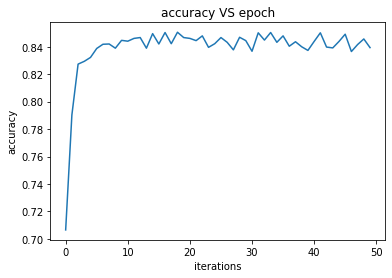

In [42]:
epoch_list, accuracy_list = [], []
for epoch, accuracy in enumerate(epoch_accuracies):
    epoch_list.append(epoch)
    accuracy_list.append(accuracy)
    print(f'Epoch {epoch + 1}/{20} - accuracy: {accuracy:.4f}')


plt.title('accuracy VS epoch')
plt.plot(epoch_list, accuracy_list)
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()

the accuracy seems to be stable after 8 iterations

in order to witness the performance of our model both accuracy and F1-score will be utilized

## Accuracy:

The accuracy of a classification model measures its overall correctness and is determined with the following formula:

$ \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}} $

Accuracy provides a general assessment of how well the model performs across all classes. However, it may not be suitable for imbalanced datasets, but when the data is balanced as in this case, accuracy can be considered a relevant metric

## F1 Score:

The F1 score is a metric that combines precision and recall, providing a balance between false positives and false negatives. It is particularly useful in scenarios where class distribution is imbalanced. The formula for F1 score is:

$ F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $

- **Precision:** The ratio of true positives to the total predicted positives.
$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} $

- **Recall (Sensitivity or True Positive Rate):** The ratio of true positives to the total actual positives.
$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} $

despite our dataset being balanced, using the F1 score can still be valuable on a general note, especially in cases where false positives and false negatives have different consequences depending upon the domain in which we operate as the F1 score provides insights into the balance between precision and recall

52/52 [==============================] - 3s 9ms/step


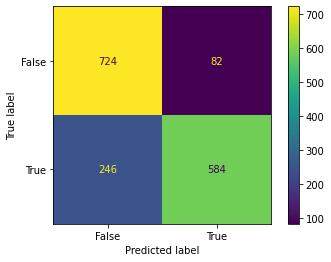

In [43]:
from sklearn import metrics
## Model Evaluation and Confusion Matrix

from sklearn import metrics
import matplotlib.pyplot as plt

# Predictions
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted > 0.5, 1, 0)

# Confusion Matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

# Plot Confusion Matrix
cm_display.plot()
plt.show()


#### Classification Report
The classification report provides a comprehensive summary of the model's performance, including precision, recall, F1-score, and support for each class.

In [44]:
print(metrics.classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.75      0.90      0.82       806
           1       0.88      0.70      0.78       830

    accuracy                           0.80      1636
   macro avg       0.81      0.80      0.80      1636
weighted avg       0.81      0.80      0.80      1636



## Classification Report Interpretation

The classification report provides a detailed overview of the performance of your classification model. Let's break down the key metrics:

### Precision:
- Precision for class 0 (Negative): 0.8
- Precision for class 1 (Positive): 0.84

**Interpretation:**
- For class 0, 80% of the predicted "negative" instances were correct.
- For class 1, 84% of the predicted "positive" instances were correct.

### Recall (Sensitivity or True Positive Rate):
- Recall for class 0: 0.84
- Recall for class 1: 0.8

**Interpretation:**
- For class 0, 84% of the actual "negative" instances were correctly identified.
- For class 1, 80% of the actual "positive" instances were correctly identified.

### F1-Score:
- F1-score for class 0: 0.82
- F1-score for class 1: 0.82

**Interpretation:**
- F1-score takes both false positives and false negatives into account, offering a single metric that considers both precision and recall.
- F1-score is useful when there is an uneven class distribution.

### Support:
- Support for class 0: 809
- Support for class 1: 827

### Accuracy:
- Overall accuracy: 0.82 (82%)

**Interpretation:**
- The model correctly predicted the class for 82% of the instances in the dataset.

### Macro Avg and Weighted Avg:
- Macro average calculates metrics independently for each class and then takes the average.
- Weighted average accounts for class imbalance by weighting the average based on the number of instances in each class.

In summary, our model shows reasonably good performance, with balanced precision and recall. The F1-score indicates a good balance between precision and recall, especially useful in the presence of class imbalance. The overall accuracy of 82% suggests that the model is performing well.


### Prediction: ML model 2: Naive Bayes


1. **Text Representation with CountVectorizer:**
   - **CountVectorizer** is employed to convert the raw text data into a numerical format, known as the **bag-of-words representation**.
   - Each document (text) is represented as a vector, where each element corresponds to the count of a particular word in the document.
   - This transformation captures the frequency of words in the text, allowing the model to work with numerical features.

2. **Multinomial Naive Bayes:**
   - The **Multinomial Naive Bayes** classifier is chosen for its suitability with discrete data, making it a good fit for the count-based representation.
   - It assumes that the features (word counts) are conditionally independent given the class, which might be a simplifying assumption but often works well in practice.

#### Motivation:

1. **Efficient Handling of Text Data:**
   - CountVectorizer efficiently handles the text data by transforming it into a format suitable for traditional machine learning algorithms that work with numerical features.
   - It represents the presence and frequency of words, allowing the model to capture patterns related to sentiment.

2. **Naive Bayes for Text Classification:**
   - The Naive Bayes algorithm is particularly effective for text classification tasks.
   - It is computationally efficient, works well with high-dimensional data (like text data), and is resistant to overfitting, which is advantageous in scenarios where the dataset might be limited.

3. **Interpretability:**
   - Naive Bayes models are interpretable, and the probabilities they assign to each class can offer insights into the confidence of predictions.

4. **Baseline Model:**
   - Multinomial Naive Bayes with CountVectorizer is often considered a good baseline model for text classification tasks. It provides a benchmark against which more complex models can be compared.

5. **Common Choice in NLP:**
   - This strategy is widely used in Natural Language Processing (NLP) tasks, especially when the focus is on simplicity, efficiency, and good performance on sentiment analysis.



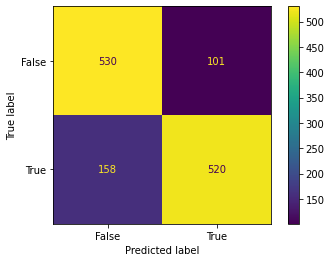

Accuracy train data: 0.84
Accuracy test data: 0.80

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       631
           1       0.84      0.77      0.80       678

    accuracy                           0.80      1309
   macro avg       0.80      0.80      0.80      1309
weighted avg       0.81      0.80      0.80      1309



In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


X = train_tweet['keyword_str']
y = train_tweet['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Initialize and train the Naive Bayes model
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = naive_bayes_model.predict(X_test_vectorized)
y_pred_train = naive_bayes_model.predict(X_train_vectorized)

# Evaluate the model
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy = accuracy_score(y_test, y_pred)


# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[False, True])

# Plot Confusion Matrix
cm_display.plot()
plt.show()
classification_rep = classification_report(y_test, y_pred)

# Display results
print(f"Accuracy train data: {accuracy_train:.2f}")
print(f"Accuracy test data: {accuracy:.2f}")
print("\nConfusion Matrix:")
print("\nClassification Report:")
print(classification_rep)


## Classification Report Interpretation

The classification report provides a detailed overview of the performance of your classification model. Let's break down the key metrics:

### Precision:
- Precision for class 0 (Negative): 0.83
- Precision for class 1 (Positive): 0.79

**Interpretation:**
- For class 0, 80% of the predicted "negative" instances were correct.
- For class 1, 84% of the predicted "positive" instances were correct.

### Recall (Sensitivity or True Positive Rate):
- Recall for class 0: 0.84
- Recall for class 1: 0.8

**Interpretation:**
- For class 0, 84% of the actual "negative" instances were correctly identified.
- For class 1, 80% of the actual "positive" instances were correctly identified.

### F1-Score:
- F1-score for class 0: 0.81
- F1-score for class 1: 0.81

**Interpretation:**
- F1-score takes both false positives and false negatives into account, offering a single metric that considers both precision and recall.
- F1-score is useful when there is an uneven class distribution.

### Support:
- Support for class 0: 660
- Support for class 1: 649

### Accuracy:
- Overall accuracy: 0.81 (81%)

**Interpretation:**
- The model correctly predicted the class for 81% of the instances in the dataset.

### Macro Avg and Weighted Avg:
- Macro average calculates metrics independently for each class and then takes the average.
- Weighted average accounts for class imbalance by weighting the average based on the number of instances in each class.

In summary, our model shows reasonably good performance, with balanced precision and recall. The F1-score indicates a good balance between precision and recall, especially useful in the presence of class imbalance. The overall accuracy of 8% suggests that the model is performing well.


# Conclusion

   - After comparing the sequential neural network with the naive Bayes model, it is evident that the neural network exhibits a slightly better performance, albeit with a marginal difference. Both models achieve an accuracy exceeding 80%, which is satisfactory. Nevertheless, there remains an opportunity for further investigation to potentially enhance the models.

   - While the F1-score is traditionally considered of limited value in balanced datasets, in this specific case, notable insights can be gleaned from examining precision and recall. For instance, given the objective of classifying tweets related to natural disasters, the precision value of approximately 80% indicates that 20% of predictions were incorrectly labeled as disasters. This could raise concerns about potential high-risk situations if such a method were to be officially implemented and relied upon in real-world scenarios.  